In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange

from src.ksd.models import create_mixture_gaussian
from src.ksd.langevin import Langevin

In [2]:
print(np.exp(1), np.exp(5), np.exp(10))
print((np.exp(1) + np.exp(5) + np.exp(10)) / 3., np.exp((1+5+10)/3.))

2.718281828459045 148.4131591025766 22026.465794806718
7392.532411912584 207.1272488898345


# Langevin dynamics

In [20]:
tf.random.set_seed(0)

In [21]:
delta = 4.
n = 500
dim = 5
num_est = 10000

target = create_mixture_gaussian(dim=dim, delta=delta)
one_component_mean = - delta * tf.eye(dim)[:, 0]

proposal_off = tfd.MultivariateNormalDiag(one_component_mean)
# proposal_off = tfd.MultivariateNormalDiag(0.*one_component_mean, 6*tf.ones(dim))
proposal_on = create_mixture_gaussian(dim=dim, delta=delta)

In [22]:
off_samples = proposal_off.sample(n)
on_samples = proposal_on.sample(n)

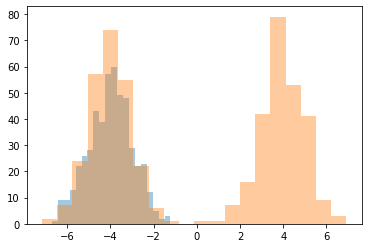

In [23]:
_ = plt.hist(off_samples.numpy()[:, 0], bins=20, label="off-target", alpha=0.4)
_ = plt.hist(on_samples.numpy()[:, 0], bins=20, label="target", alpha=0.4)

In [24]:
langevin_off = Langevin(log_prob=proposal_on.log_prob)

In [28]:
steps = 1000
step_size = 1e-2
x_init_off = tf.identity(off_samples)

langevin_off.run(steps=steps, step_size=step_size, x_init=x_init_off)

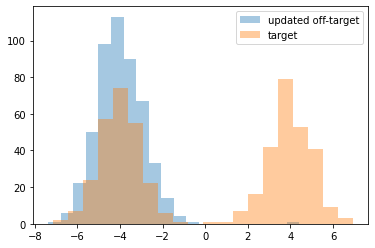

In [29]:
_ = plt.hist(langevin_off.x.numpy()[-1, :, 0], bins=20, label="updated off-target", alpha=0.4)
_ = plt.hist(on_samples.numpy()[:, 0], bins=20, label="target", alpha=0.4)
_ = plt.legend()

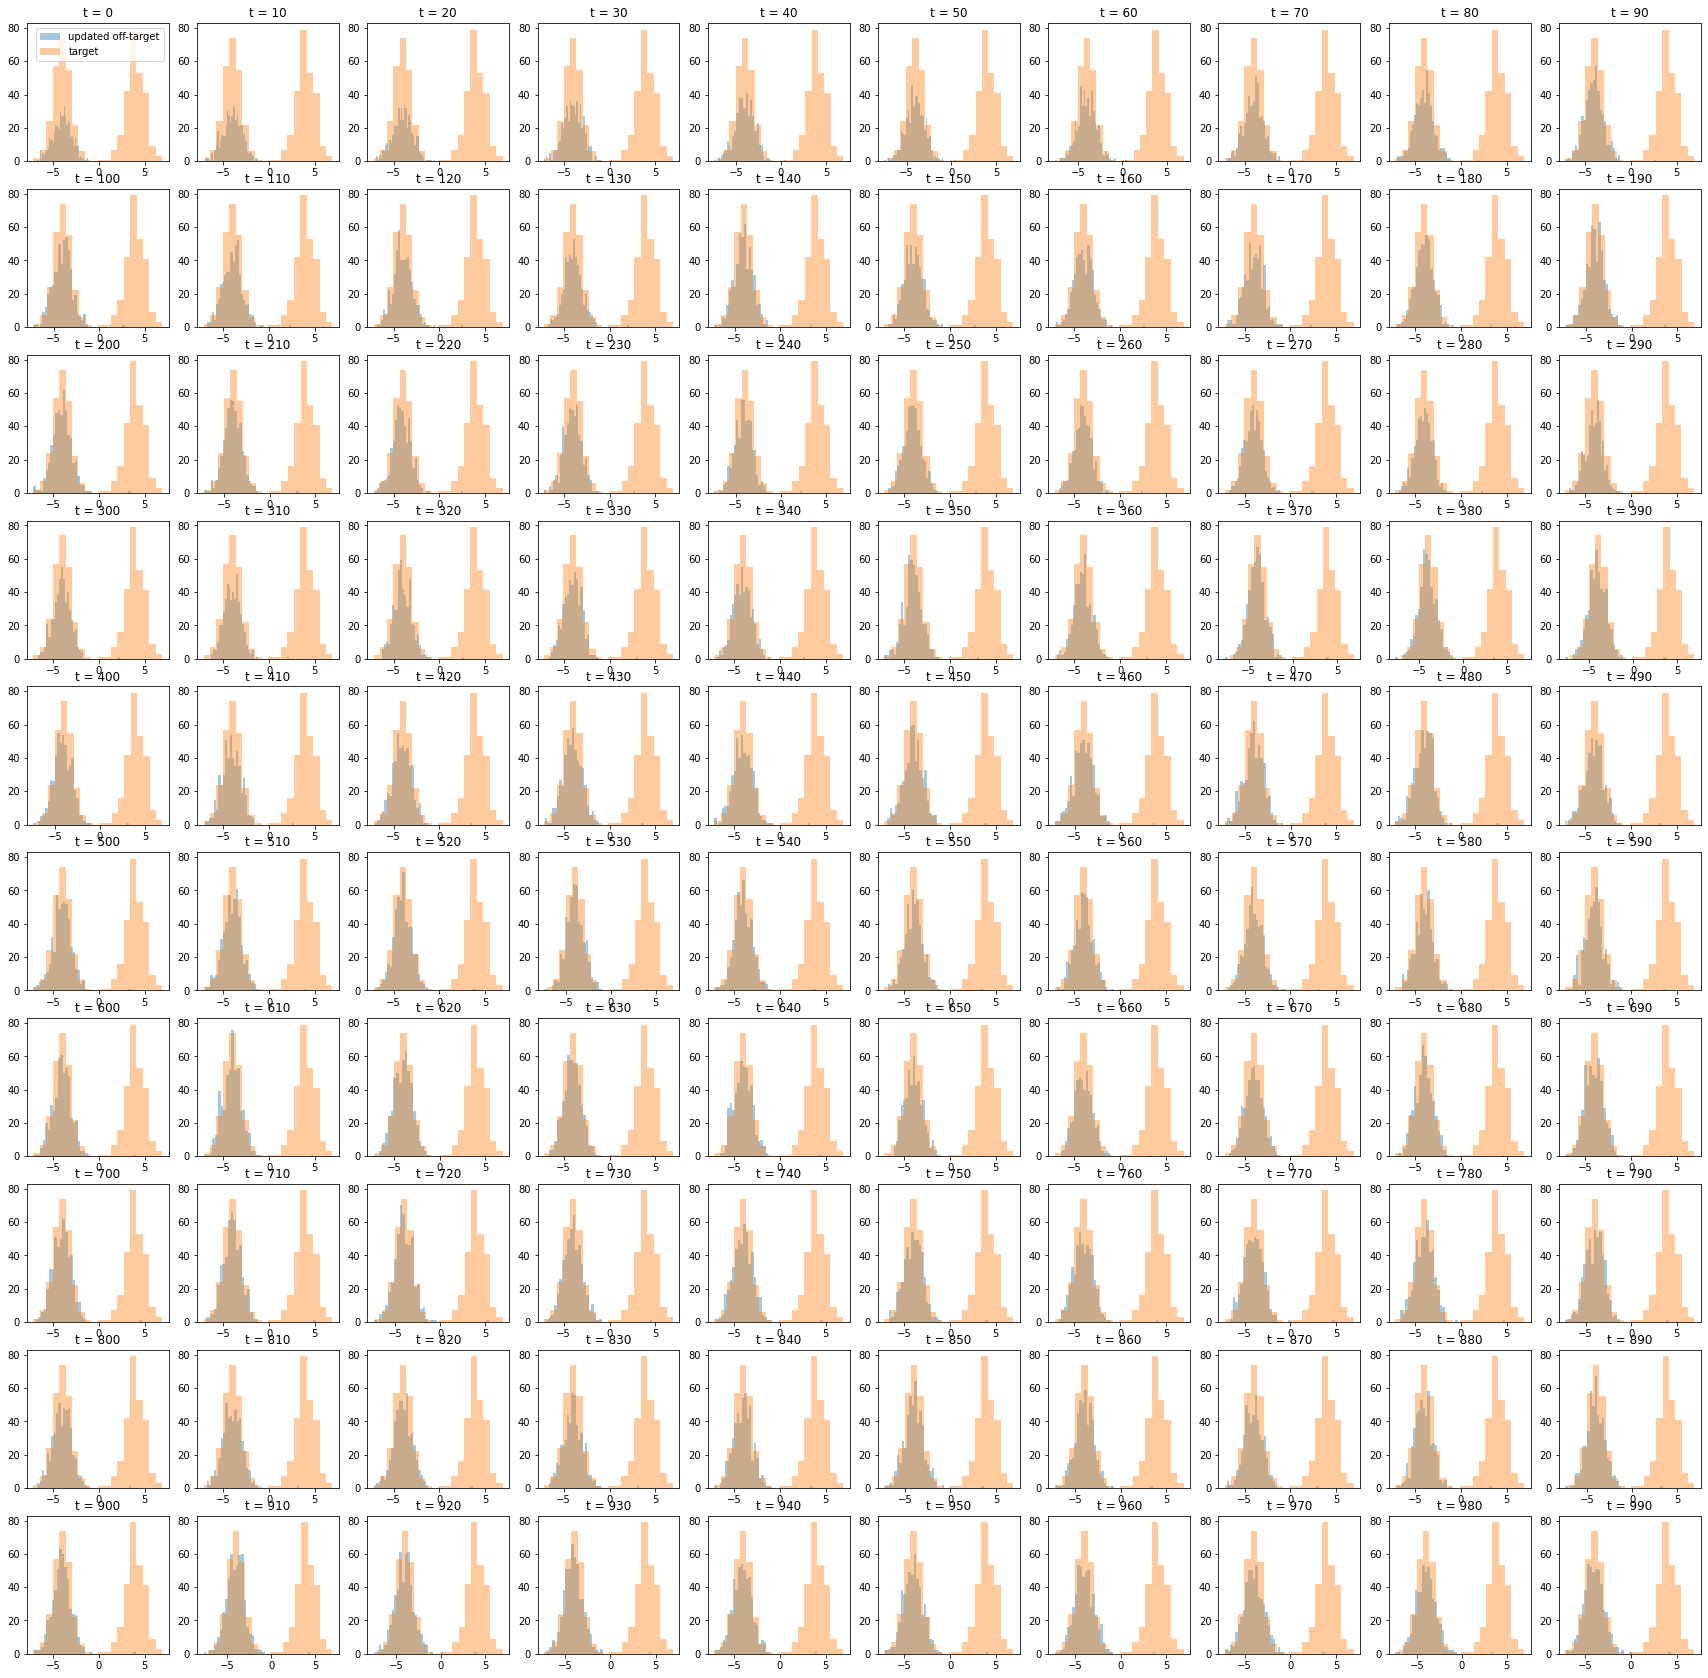

In [30]:
nplots = 100 # steps
nrows = int(np.sqrt(nplots))
ncols = int(np.ceil(nplots / nrows))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*nrows, 3*ncols))

ind = 0
t = 0
for row in ax:
    for col in row:
        if ind >= nplots: break
            
        col.hist(langevin_off.x.numpy()[t, :, 0], bins=40, label="updated off-target", alpha=0.4)
        col.hist(on_samples.numpy()[:, 0], bins=20, label="target", alpha=0.4)
        col.set_title(f"t = {t}")
        if t == 0:
            col.legend()
        
        ind += 1
        t += 10

In [29]:
langevin_on = Langevin(log_prob=proposal_on.log_prob)

x_init_on = tf.identity(on_samples)
langevin_on.run(steps=steps, step_size=step_size, x_init=x_init_on)

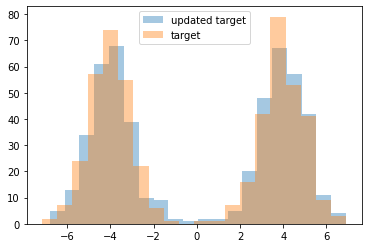

In [30]:
_ = plt.hist(langevin_on.x.numpy()[-1, :, 0], bins=20, label="updated target", alpha=0.4)
_ = plt.hist(on_samples.numpy()[:, 0], bins=20, label="target", alpha=0.4)
_ = plt.legend()

# KSD as a function of number of steps

In [31]:
from src.ksd.ksd import KSD
from src.ksd.kernel import RBF, IMQ

In [32]:
tf.random.set_seed(0)

In [33]:
kernel = IMQ(med_heuristic=True)

ksd = KSD(target=target, kernel=kernel)

nrep = 10

In [34]:
def run_langevin_experiment(nrep, proposal_off, proposal_on, steps, step_size):
    ksd_df = pd.DataFrame(columns=["t", "ksd", "seed", "type"])

    iterator = trange(nrep)
    for seed in iterator:
        off_samples = proposal_off.sample(n)
        on_samples = proposal_on.sample(n)
        
        x_init_off = off_samples
        x_init_on = on_samples

        langevin_off = Langevin(log_prob=proposal_on.log_prob)
        langevin_off.run(steps=steps, step_size=step_size, x_init=x_init_off)

        langevin_on = Langevin(log_prob=proposal_on.log_prob)
        langevin_on.run(steps=steps, step_size=step_size, x_init=x_init_on)

        for t in range(steps):
            iterator.set_description(f"Time step {t+1} of {steps}")

            x_t = langevin_off.x[t, :, :].numpy()
            ksd_val = ksd(x_t, tf.identity(x_t)).numpy()
            ksd_df.loc[len(ksd_df)] = [t, ksd_val, seed, "off-target"]
            
            x_t = langevin_on.x[t, :, :].numpy()
            ksd_val = ksd(x_t, tf.identity(x_t)).numpy()
            ksd_df.loc[len(ksd_df)] = [t, ksd_val, seed, "target"]
            
    return ksd_df

In [35]:
ksd_df = run_langevin_experiment(
    nrep=nrep, 
    proposal_off=proposal_off, 
    proposal_on=proposal_on, 
    steps=1000, 
    step_size=1e-2)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:xlabel='t', ylabel='ksd'>

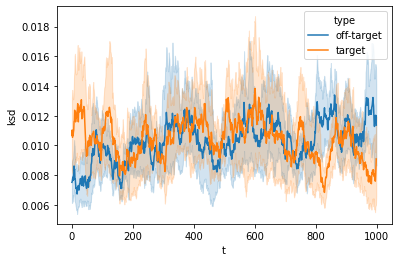

In [36]:
sns.lineplot(data=ksd_df.loc[ksd_df.t <= 1000], x="t", y="ksd", hue="type")

# Check if the test controls p-value

In [ ]:
from src.ksd.ksd import KSD
from src.ksd.kernel import RBF, IMQ

In [ ]:
tf.random.set_seed(0)

In [ ]:
kernel = IMQ(med_heuristic=True)

ksd = KSD(target=target, kernel=kernel)

nrep = 10